**Author:** Matt Sarmiento

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-1">Functions</a></span></li><li><span><a href="#Data-Clean" data-toc-modified-id="Data-Clean-2">Data Clean</a></span><ul class="toc-item"><li><span><a href="#Datasets" data-toc-modified-id="Datasets-2.1">Datasets</a></span></li><li><span><a href="#Synthetic-Opioids" data-toc-modified-id="Synthetic-Opioids-2.2">Synthetic Opioids</a></span></li><li><span><a href="#All-Drugs" data-toc-modified-id="All-Drugs-2.3">All Drugs</a></span></li><li><span><a href="#Provisional-Counts" data-toc-modified-id="Provisional-Counts-2.4">Provisional Counts</a></span></li><li><span><a href="#Concat" data-toc-modified-id="Concat-2.5">Concat</a></span></li></ul></li><li><span><a href="#Plot" data-toc-modified-id="Plot-3">Plot</a></span><ul class="toc-item"><li><span><a href="#Geoms" data-toc-modified-id="Geoms-3.1">Geoms</a></span></li><li><span><a href="#Annotations-&amp;-Plot" data-toc-modified-id="Annotations-&amp;-Plot-3.2">Annotations &amp; Plot</a></span></li></ul></li></ul></div>

In [368]:
# Third-party libs
import pandas as pd

In [3]:
# Load rpy2 extension (may need to re-run)
%reload_ext rpy2.ipython

In [7]:
# Load R libraries
%R library(ggplot2, scales)

array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U9')

----------------------

# Functions

TODO: Put these in a library and import it instead

In [415]:
# Function to handle NaN values
# STATUS: We're not using this, yet...

def handle_nan(df):
    """Return the given dataframe with each column of pandas type `object`
    cast explicitly to `str`.
    
    For example, columns with `float` and `str` entries will have all 
    `float` entries cast to `str`.
    
    Args:
        df: Pandas DataFrame
    
    Returns:
        frame: Pandas DataFrame with each column of homogeneous type.
    """
    # We want to return a new DataFrame, not modify the original
    frame = df.copy()
    
    columns = frame.columns
    for col in columns:
        # Checks if col is of type `object`
        if frame[col].dtype == np.object:
            # Replaces `NaN` entries with the string "NA" 
            frame[col] = frame[col].fillna("NA") 
    
    return frame

In [405]:
# Function to handle integer entries with commas, e.g. "1,532"
def in2float(series):
    """Strip commas and casts series to float"""
    # Want to return a copy
    seriesC = series.copy()
    
    seriesC = seriesC.str.replace(",", "")
    seriesC = seriesC.astype(float)
    
    return seriesC

--------------

# Data Clean

## Datasets

We'll look at the following datasets:
1. Deaths per year due to synthetic opioids, 1999-2017
2. Deaths per year due to all drugs, 1999-2017
3. Provisional deaths per year per drug type, 2015 - Feb. 2019

**Note:** The provisional deaths are counted on a rolling 12-month-period basis, e.g. counts for December 2018 are for the period Jan. - Dec. 2018.

**Important:** For each rolling 12-month period the provisional dataset contains
* Confirmed death counts
* Predicted death counts

We will use the predicted death counts for our 2018 figures. Our reasoning is:
* The data is provisional in any case, so no harm is done in using non-confirmed counts
* The confirmed counts are guaranteed to be undercounts. Also, there is some sound statistical prediction behind the predicted counts and we believe in their soundness.

Visit https://www.cdc.gov/nchs/nvss/vsrr/drug-overdose-data.htm for more background on how predictions are made

## Synthetic Opioids 


In [373]:
# Deaths due to synthetic opioids (e.g. fentanyl) per year
synthetic = pd.read_csv('../input/synthetic-deaths-per-year.csv', sep='\t')

In [374]:
synthetic.head(1)

,Notes,Year,Year Code,Deaths,Population,Crude Rate,Age Adjusted Rate
0,NaN,1999.0,1999.0,730.0,279040168.0,0.3,0.3


In [375]:
# Drop Notes column
synthetic = synthetic.drop(columns=["Notes"])

# Drop rows with Year = NaN
synthetic = synthetic.loc[synthetic.Year.isna() == False]

In [376]:
synthetic.head(3)

,Year,Year Code,Deaths,Population,Crude Rate,Age Adjusted Rate
0,1999.0,1999.0,730.0,279040168.0,0.3,0.3
1,2000.0,2000.0,782.0,281421906.0,0.3,0.3
2,2001.0,2001.0,957.0,284968955.0,0.3,0.3


In [176]:
# Split frame at jump in fentanyl overdoses (2014-15)
# (for colour-coding in ggplot)
synthetic_pre2014 = synthetic[:15]
synthetic_post2014 = synthetic[14:]

## All Drugs

In [459]:
# Deaths from all drugs per year
drugs = pd.read_csv('../input/deaths-per-year.csv', sep='\t')
drugs.head(1)

,Notes,Year,Year Code,Deaths,Population,Crude Rate,Age Adjusted Rate
0,NaN,1999.0,1999.0,16849.0,279040168.0,6.0,6.1


In [460]:
# Drop Notes column
drugs = drugs.drop(columns=["Notes"])

# Drop rows with Year = Nan
drugs = drugs.loc[drugs.Year.isna() == False]

In [461]:
drugs.tail(3)

,Year,Year Code,Deaths,Population,Crude Rate,Age Adjusted Rate
16,2015.0,2015.0,52404.0,321418820.0,16.3,16.3
17,2016.0,2016.0,63632.0,323127513.0,19.7,19.8
18,2017.0,2017.0,70237.0,325719178.0,21.6,21.7


In [177]:
# Split frame at jump in fentanyl overdoses (2014-15)
drugs_pre2014 = drugs[:15]
drugs_post2014 = drugs[14:]

## Provisional Counts

In [576]:
# Load data
types_prov = pd.read_csv('../input/provisional-deaths-per-type-2019.csv')
types_prov.head(1)

,State,Year,Month,Period,Indicator,Data Value,Percent Complete,Percent Pending Investigation,State Name,Footnote,Footnote Symbol,Predicted Value
0,AK,2015,April,12 month-ending,Natural & semi-synthetic opioids (T40.2),NaN,100,0.0,Alaska,Numbers may differ from published reports usin...,**,NaN


In [512]:
# Gets 2018 data for U.S.
types2018 = (types_prov.loc[(types_prov.State == "US") & 
                            (types_prov.Year == 2018)  &
                            (types_prov.Month == "December")])

# Selects cols we want
# Reminder: We're using Predicted values for death counts
types2018 = types2018[["State", "Year", "Indicator", "Predicted Value"]]
types2018.columns = ["State", "Year", "Indicator", "Deaths"]

# Converts series to float
types2018["Deaths"] = in2float(types2018["Deaths"])

In [513]:
# Gets overdose counts for synthetic opioids for entire U.S.
synth2018 = types2018.loc[types2018.Indicator.str.startswith("Synthetic")]

# Gets overdose counts for all opioids for entire U.S.
opioids2018 = types2018.loc[types2018.Indicator.str.startswith("Opioids")]

# Gets overdose counts for all drugs for entire U.S.
all2018 = types2018.loc[types2018.Indicator == "Number of Drug Overdose Deaths"]

In [525]:
# Selects final cols we want
synth2018 = synth2018[["Year", "Deaths"]]
all2018 = all2018[["Year", "Deaths"]]

all2018

,Year,Deaths
18759,2018,68618.0


## Concat

We need to join the provisional data to our previous datasets to get the 2017 data point. This will let us plot a geom_line for 2017-2018.

In [518]:
# Concatenate frames
synth_all = pd.concat([synthetic, synth2018], sort=False, ignore_index=True)
drugs_all = pd.concat([drugs, all2018], sort=False, ignore_index=True)

In [575]:
# Split off 2017-18 data points
synth_new = synth_all[-2:]
all_new = drugs_all[-2:]

all_new

,Year,Year Code,Deaths,Population,Crude Rate,Age Adjusted Rate
18,2017.0,2017.0,70237.0,325719178.0,21.6,21.7
19,2018.0,NaN,68618.0,NaN,NaN,NaN


---------------------

# Plot

In [526]:
# Push data to R
%R -i synthetic_pre2014
%R -i synthetic_post2014

%R -i drugs_pre2014
%R -i drugs_post2014

%R -i synth_new
%R -i all_new

In [597]:
%%R

# Custom Theme
theme_custom <- theme(panel.grid.major = element_blank(),
                      panel.grid.minor = element_blank(),
                      axis.text.y = element_blank(),
                      axis.title = element_blank(),
                      plot.title = element_text(size = 24, colour = "grey20", vjust = 2),
                      plot.subtitle = element_text(size = 16, colour = "grey40", vjust = 0))

# Colours
highlight = "violetred2"
lwidth = 0.8

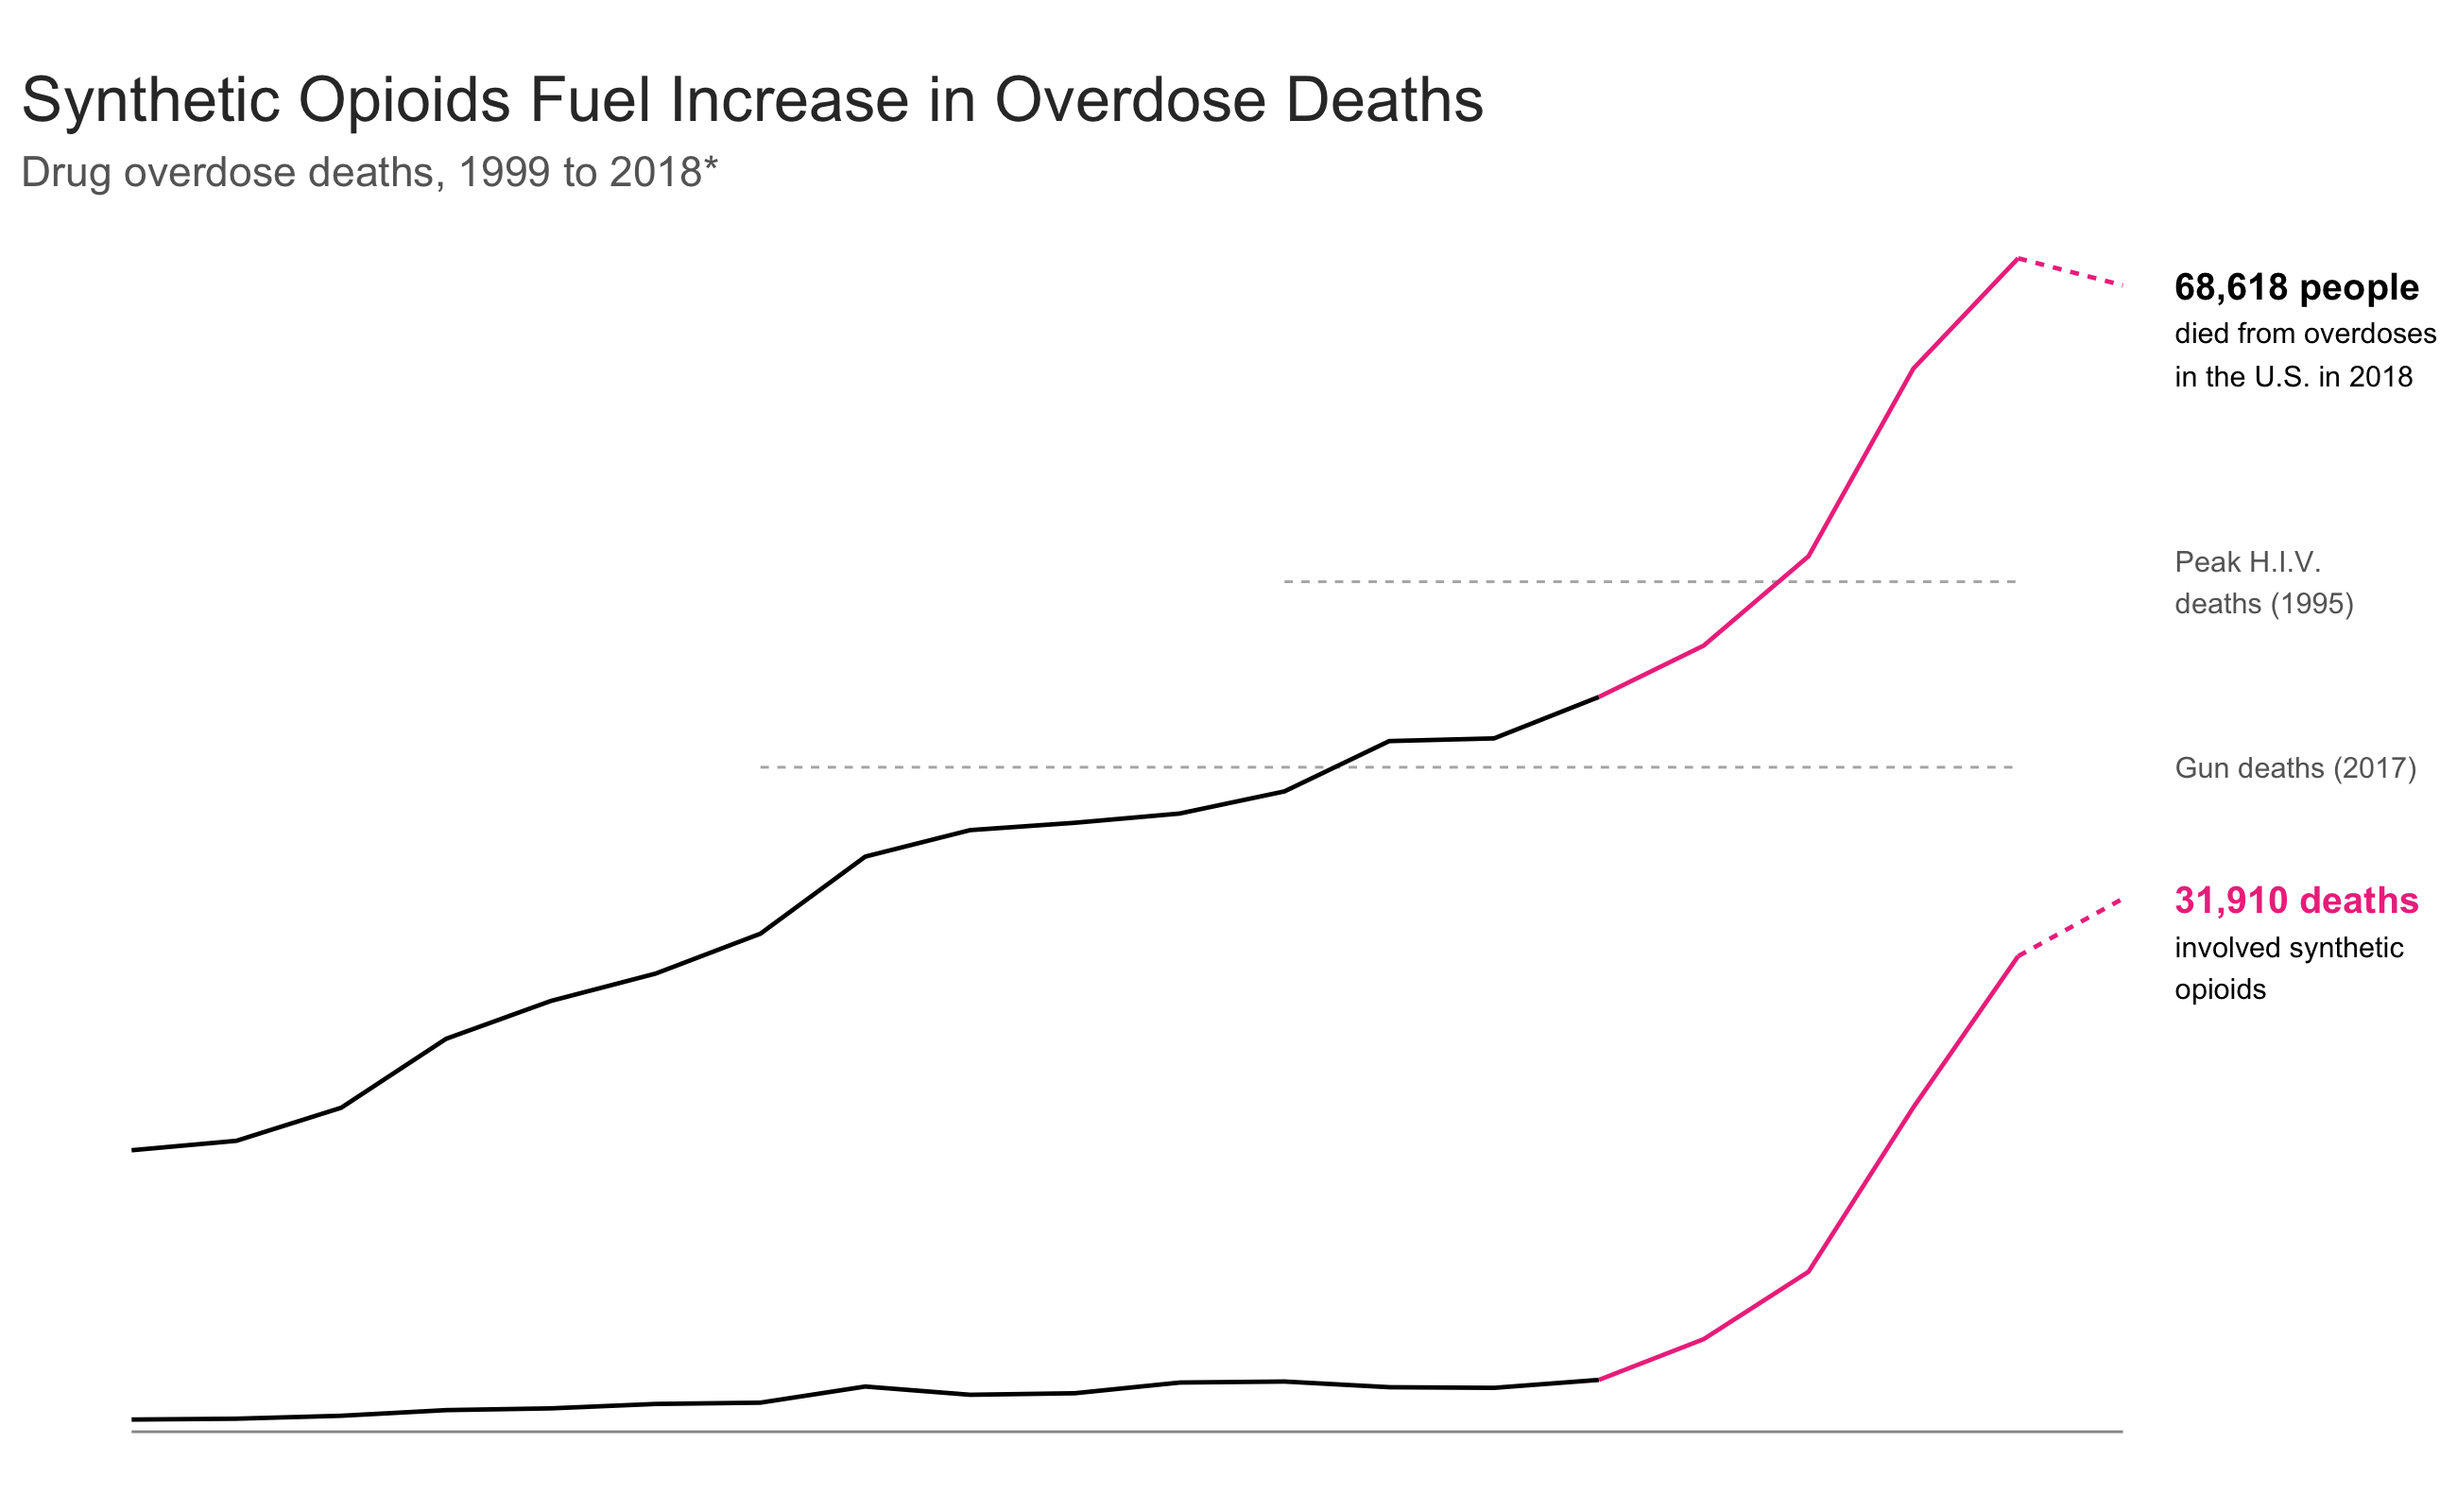

In [617]:
%%R -h 8 -w 13 -u in -r 200


# Base
q <- ggplot()

# AIDS horizontal ref
q <- q + geom_segment(aes(x = 2010, y = 50877, xend = 2017, yend = 50877), linetype = "33", colour = "grey70")
q <- q + annotate("text", label = "Peak H.I.V.\ndeaths (1995)", x = 2018.5, y = 50877, hjust = 0, colour = "grey40")

# 2017 Gun deaths horizontal ref
q <- q + geom_segment(aes(x = 2005, y = 39773, xend = 2017, yend = 39773), linetype = "33", colour = "grey70")
q <- q + annotate("text", label = "Gun deaths (2017)", x = 2018.5, y = 39773, hjust = 0, colour = "grey40")

# 1999-2014 data
q <- q + geom_line(aes(x = Year, y = Deaths), data = drugs_pre2014, size = lwidth)
q <- q + geom_line(aes(x = Year, y = Deaths), data = synthetic_pre2014, size = lwidth)

# 2014-2017 data
q <- q + geom_line(aes(x = Year, y = Deaths), data = drugs_post2014, colour = highlight, size = lwidth)
q <- q + geom_line(aes(x = Year, y = Deaths), data = synthetic_post2014, colour = highlight, size = lwidth)

# Provisional 2018 data
q <- q + geom_line(aes(x = Year, y = Deaths), data = all_new, colour = highlight, linetype = "22", size = lwidth)
q <- q + geom_line(aes(x = Year, y = Deaths), data = synth_new, colour = highlight, linetype = "22", size = lwidth)


##################################################


# Synthetic deaths annotation
q <- q + annotate("text", label = "31,910 deaths", x = 2018.5, y = 31910, hjust = 0, fontface = "bold", size = 5,
                  colour = highlight)
q <- q + annotate("text", label = "involved synthetic\nopioids", x = 2018.5, y = 27800, hjust = 0)

# Total deaths annotation
q <- q + annotate("text", label = "68,618 people", x = 2018.5, y = 68618, hjust = 0, fontface = "bold", size = 5)
q <- q + annotate("text", label = "died from overdoses", x = 2018.5, y = 65800, hjust = 0)
q <- q + annotate("text", label = "in the U.S. in 2018", x = 2018.5, y = 63200, hjust = 0)


# Titles
q <- q + labs(title = "\nSynthetic Opioids Fuel Increase in Overdose Deaths")
q <- q + labs(subtitle = "Drug overdose deaths, 1999 to 2018*")

# Axes
q <- q + scale_x_continuous(limits = c(1999, 2020), labels = NULL)
q <- q + geom_segment(aes(x = 1999, y = 0, xend = 2018, yend = 0), colour = "grey40", alpha = 0.7)

# Themes
q <- q + theme_minimal() + theme_custom

q